# VGG Testing

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import keras
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Bidirectional, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Lambda, MaxPool2D, BatchNormalization, Input, concatenate, Reshape, LSTM, CuDNNLSTM
#from keras.layers import K
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from keras import applications
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [3]:
class1 = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
class2 = {0:'Mononuclear',1:'Polynuclear'}
tree_path = 'C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\BCCD\\Annotations'
image_path = 'C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\BCCD\\JPEGImages'

## Define Helper Functions and Load Data

In [5]:
def get_data(folder, size):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = cv2.resize(img_file, dsize=size)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [6]:
from PIL import Image
size=(64, 64)
X_train, y_train, z_train = get_data('C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\dataset2-master\\images\\TRAIN\\', size)
X_test, y_test, z_test = get_data('C:\\Users\\Chris\\Blood Cells\\BCCD_Dataset-master\\dataset2-master\\images\\TEST\\', size)

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:00<00:00, 769.42it/s]


In [5]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)

# Normalize to [0,1]
X_train=np.array(X_train)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test=X_test/255.0

## Import VGG with Pretrained Weights

In [18]:
vgg = applications.vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(64, 64,3))

Don't retrain bottom layers

In [19]:
for layer in vgg.layers[:-4]:
    layer.trainable=False
for layer in vgg.layers:
    print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000022DDBD90048> False
<keras.layers.convolutional.Conv2D object at 0x0000022DDBD90808> False
<keras.layers.convolutional.Conv2D object at 0x0000022D87A95708> False
<keras.layers.pooling.MaxPooling2D object at 0x0000022DDBD903C8> False
<keras.layers.convolutional.Conv2D object at 0x0000022D87AF3D08> False
<keras.layers.convolutional.Conv2D object at 0x0000022FB8AEA0C8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000022FB8B46388> False
<keras.layers.convolutional.Conv2D object at 0x0000022FB8B46308> False
<keras.layers.convolutional.Conv2D object at 0x0000022FB8B64A88> False
<keras.layers.convolutional.Conv2D object at 0x0000022FB8B9B608> False
<keras.layers.pooling.MaxPooling2D object at 0x0000022FB8BA5F88> False
<keras.layers.convolutional.Conv2D object at 0x0000022FB8BC17C8> False
<keras.layers.convolutional.Conv2D object at 0x0000022FB8BDFD48> False
<keras.layers.convolutional.Conv2D object at 0x0000022FB8C17788> False
<ker

In [20]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(128, activation='relu' ))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

In [21]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 14,977,605
Trainable params: 7,342,341
Non-trainable params: 7,635,264
_________________________________________________________________


In [22]:
#Training Parameters 
batch_size  = 128
epochs      = 50

#Input Data parameters
num_classes = 5
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 3)


datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

history = model.fit_generator(datagen.flow(X_train,y_trainHot, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data = [X_test, y_testHot], verbose=2)

Epoch 1/50
 - 10s - loss: 1.5333 - acc: 0.2908 - val_loss: 1.2877 - val_acc: 0.3707
Epoch 2/50
 - 8s - loss: 1.0490 - acc: 0.5293 - val_loss: 1.0473 - val_acc: 0.5312
Epoch 3/50
 - 8s - loss: 0.6897 - acc: 0.7097 - val_loss: 0.8925 - val_acc: 0.6731
Epoch 4/50
 - 8s - loss: 0.5431 - acc: 0.7755 - val_loss: 1.0149 - val_acc: 0.6671
Epoch 5/50
 - 8s - loss: 0.3849 - acc: 0.8489 - val_loss: 0.7381 - val_acc: 0.7467
Epoch 6/50
 - 8s - loss: 0.3135 - acc: 0.8710 - val_loss: 0.7473 - val_acc: 0.7547
Epoch 7/50
 - 8s - loss: 0.2762 - acc: 0.8870 - val_loss: 0.8016 - val_acc: 0.7238
Epoch 8/50
 - 8s - loss: 0.2278 - acc: 0.9041 - val_loss: 1.0671 - val_acc: 0.6868
Epoch 9/50
 - 8s - loss: 0.2228 - acc: 0.9112 - val_loss: 0.8709 - val_acc: 0.7519
Epoch 10/50
 - 8s - loss: 0.2010 - acc: 0.9190 - val_loss: 1.2887 - val_acc: 0.6852
Epoch 11/50
 - 8s - loss: 0.1729 - acc: 0.9302 - val_loss: 1.0662 - val_acc: 0.7242
Epoch 12/50
 - 8s - loss: 0.1505 - acc: 0.9410 - val_loss: 1.0650 - val_acc: 0.7205


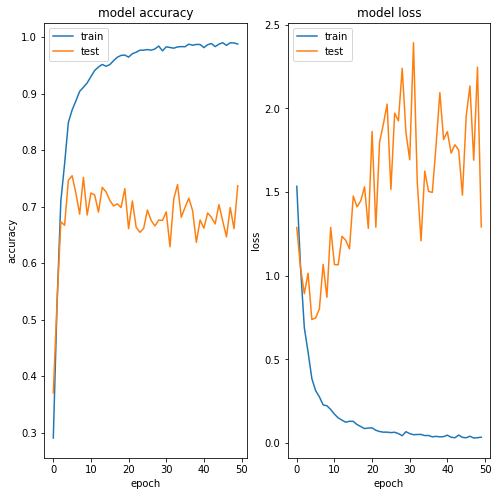

In [23]:
plot_learning_curve(history.history)
plt.show()